##### Import Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

##### Read datasets

In [4]:
CJ_releases_df = pd.read_csv('C:/MachineLearning/CJ_Releases_2022.csv')
CJ_receives_df = pd.read_csv('C:/MachineLearning/CJ_Receives_2022.csv')

### Phase I

In [5]:
# Column rename
CJ_releases_df.rename(columns={'Release Date': 'Date', 'Release Type': 'Type'}, inplace=True)
CJ_receives_df.rename(columns={'Receive Date': 'Date', 'Receive Type': 'Type'}, inplace=True)

CJ_releases_df['Record Type'] = 'Release'
CJ_receives_df['Record Type'] = 'Receive'


##### Datasets Integration

In [6]:

CriminalJustice_df = pd.concat([CJ_releases_df, CJ_receives_df], ignore_index=True)

file_path = 'C:\\CJ_ML\\CriminalJustice_df.csv'
CriminalJustice_df.to_csv(file_path, index=False)

In [7]:
# Define data type
data_types = CriminalJustice_df.dtypes

print(data_types)

Date                   object
Type                   object
Inmate Type            object
Gender                 object
Race                   object
Age                     int64
County                 object
Offense Code            int64
Offense                object
Offense Description    object
Sentence Date          object
Offense Date           object
Sentence (Years)       object
Record Type            object
dtype: object


In [8]:
# Unique values
print(CriminalJustice_df.nunique())

Date                    326
Type                     23
Inmate Type              42
Gender                    2
Race                      6
Age                      72
County                  251
Offense Code            716
Offense                   4
Offense Description     710
Sentence Date          5623
Offense Date           7783
Sentence (Years)         40
Record Type               2
dtype: int64


In [9]:
# Check for duplicate rows
duplicates = CriminalJustice_df[CriminalJustice_df.duplicated(keep='first')]

num_duplicates = duplicates.shape[0]
print(f"Number of duplicate rows: {num_duplicates}")

if num_duplicates > 0:
    print("Duplicate Rows:")
    print(duplicates)
    duplicate_indices = duplicates.index.tolist()
    print(f"Indices of duplicate rows: {duplicate_indices}")
else:
    print("No duplicate rows found.")


Number of duplicate rows: 1
Duplicate Rows:
             Date     Type Inmate Type Gender   Race  Age County  \
84000  08/01/2022  New Rcv          ID      M  Black   19  Falls   

       Offense Code  Offense        Offense Description Sentence Date  \
84000      13150005  Violent  AGG ASSLT W/DEADLY WEAPON    07/14/2022   

      Offense Date Sentence (Years) Record Type  
84000   08/26/2021         10 Years     Receive  
Indices of duplicate rows: [84000]


In [10]:
# Remove duplicate rows
CriminalJustice_df = CriminalJustice_df.drop_duplicates(keep='first')

duplicates_after_deletion = CriminalJustice_df[CriminalJustice_df.duplicated(keep='first')]
num_duplicates_after_deletion = duplicates_after_deletion.shape[0]

print(f"Number of duplicate rows after deletion: {num_duplicates_after_deletion}")
if num_duplicates_after_deletion > 0:
    print("There are still duplicate rows after deletion, which is unexpected.")
else:
    print("All duplicate rows have been successfully deleted.")

Number of duplicate rows after deletion: 0
All duplicate rows have been successfully deleted.


In [11]:
# Aggregation
CriminalJustice_df['Offense Date'] = pd.to_datetime(CriminalJustice_df['Offense Date'], errors='coerce')
CriminalJustice_df['Sentence Date'] = pd.to_datetime(CriminalJustice_df['Sentence Date'], errors='coerce')

# Calculate the difference in days and create a new column 'Days Between'
CriminalJustice_df['Days Between'] = (CriminalJustice_df['Sentence Date'] - CriminalJustice_df['Offense Date']).dt.days
print(CriminalJustice_df['Days Between'])

0         118.0
1         624.0
2         170.0
3         219.0
4         468.0
          ...  
91593    1575.0
91594     717.0
91595     426.0
91596    2225.0
91597    1225.0
Name: Days Between, Length: 91597, dtype: float64


In [12]:
# Aggregation
import re
from sklearn.preprocessing import MinMaxScaler

def sentence_to_numeric(sentence):
    if 'life' in sentence.lower().strip():
        return 100
    elif '+' in sentence:
        base_number = re.findall(r'\d+', sentence)
        return int(base_number[0]) if base_number else 0

    numbers = re.findall(r'\d+', sentence)

    if len(numbers) >= 2:
        lower, upper = map(int, numbers[:2])
        return (lower + upper) // 2
    elif numbers:
        return int(numbers[0])
    else:
        return 0

if 'Sentence (Years)' in CriminalJustice_df.columns:
    CriminalJustice_df['Sentence Numeric'] = CriminalJustice_df['Sentence (Years)'].apply(sentence_to_numeric)
else:
    print("'Sentence (Years)' column not found in the dataset.")

scaler = MinMaxScaler()
CriminalJustice_df['Sentence Scaled'] = scaler.fit_transform(CriminalJustice_df[['Sentence Numeric']].values.reshape(-1, 1))

print(CriminalJustice_df[['Sentence (Years)', 'Sentence Numeric', 'Sentence Scaled']].head())

  Sentence (Years)  Sentence Numeric  Sentence Scaled
0             Life               100             1.00
1   16 to 20 Years                18             0.18
2   31 to 40 Years                35             0.35
3   11 to 15 Years                13             0.13
4   11 to 15 Years                13             0.13


##### Handling missing values

In [13]:
# Null values
print(CriminalJustice_df.isnull().sum())

Date                      0
Type                      0
Inmate Type               0
Gender                    0
Race                      0
Age                       0
County                    0
Offense Code              0
Offense                   0
Offense Description     276
Sentence Date          8085
Offense Date              4
Sentence (Years)          0
Record Type               0
Days Between           8085
Sentence Numeric          0
Sentence Scaled           0
dtype: int64


In [14]:
# Fill missing  'Offense Description' based on the Offense Code
offense_code_to_description = CriminalJustice_df.dropna(subset=['Offense Description']).groupby('Offense Code')['Offense Description'].agg(pd.Series.mode).to_dict()
CriminalJustice_df.loc[CriminalJustice_df['Offense Description'].isnull(), 'Offense Description'] = CriminalJustice_df.loc[CriminalJustice_df['Offense Description'].isnull(), 'Offense Code'].map(offense_code_to_description)
offense_code_to_description = CriminalJustice_df.dropna(subset=['Offense Description']).groupby('Offense Code')['Offense Description'].agg(lambda x: pd.Series.mode(x).iloc[0]).to_dict()
CriminalJustice_df.loc[CriminalJustice_df['Offense Description'].isnull(), 'Offense Description'] = CriminalJustice_df.loc[CriminalJustice_df['Offense Description'].isnull(), 'Offense Code'].map(offense_code_to_description)

CriminalJustice_df['Offense Description'] = CriminalJustice_df['Offense Description'].fillna('Unknown')

In [15]:
CriminalJustice_df = CriminalJustice_df.dropna(subset=['Sentence Date', 'Offense Date', 'Days Between'], how='any')

In [16]:
# Null values
print(CriminalJustice_df.isnull().sum())

Date                   0
Type                   0
Inmate Type            0
Gender                 0
Race                   0
Age                    0
County                 0
Offense Code           0
Offense                0
Offense Description    0
Sentence Date          0
Offense Date           0
Sentence (Years)       0
Record Type            0
Days Between           0
Sentence Numeric       0
Sentence Scaled        0
dtype: int64


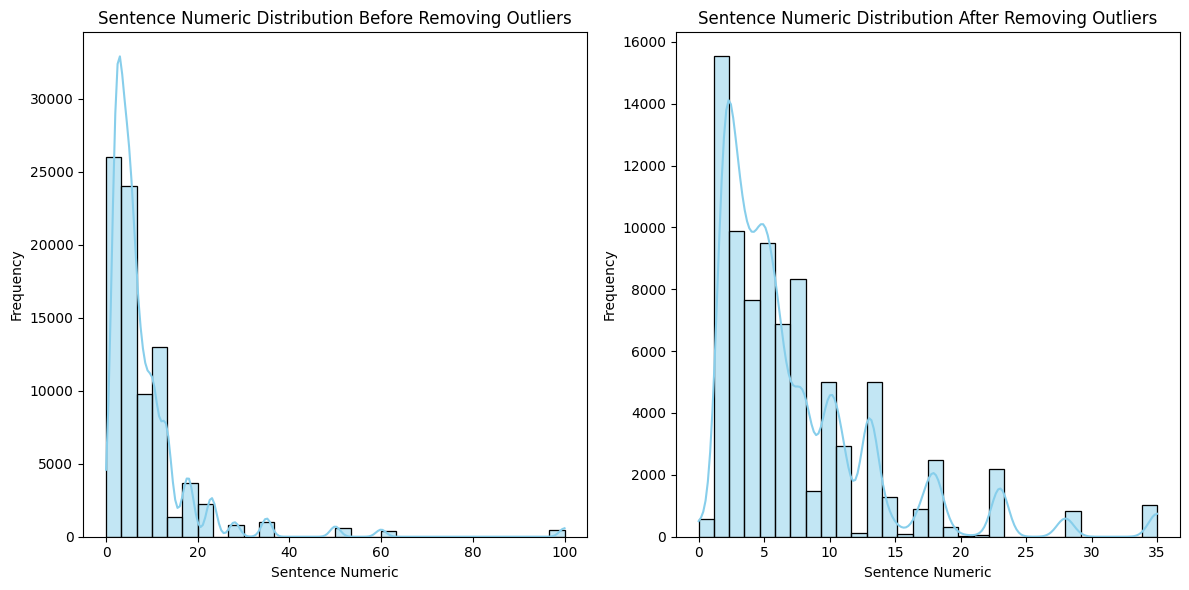

In [17]:
# Function to detect outliers using Z-score
def detect_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > threshold]
    return outliers

# Function to remove outliers using Z-score
def remove_outliers_zscore(df, column, threshold=3):
    z_scores = np.abs(stats.zscore(df[column]))
    df_no_outliers = df[z_scores <= threshold]
    return df_no_outliers

# Detect outliers in 'Age' column
outliers_age = detect_outliers_zscore(CriminalJustice_df, 'Sentence Numeric')

# Remove outliers from 'Age' column
CriminalJustice_df_no_outliers = remove_outliers_zscore(CriminalJustice_df, 'Sentence Numeric')

# Plot histograms before and after removing outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(CriminalJustice_df['Sentence Numeric'], bins=30, kde=True, color='skyblue')
plt.title("Sentence Numeric Distribution Before Removing Outliers")
plt.xlabel("Sentence Numeric")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
sns.histplot(CriminalJustice_df_no_outliers['Sentence Numeric'], bins=30, kde=True, color='skyblue')
plt.title("Sentence Numeric Distribution After Removing Outliers")
plt.xlabel("Sentence Numeric")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

In [537]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = CriminalJustice_df[['Age']] 
y = CriminalJustice_df['Offense']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


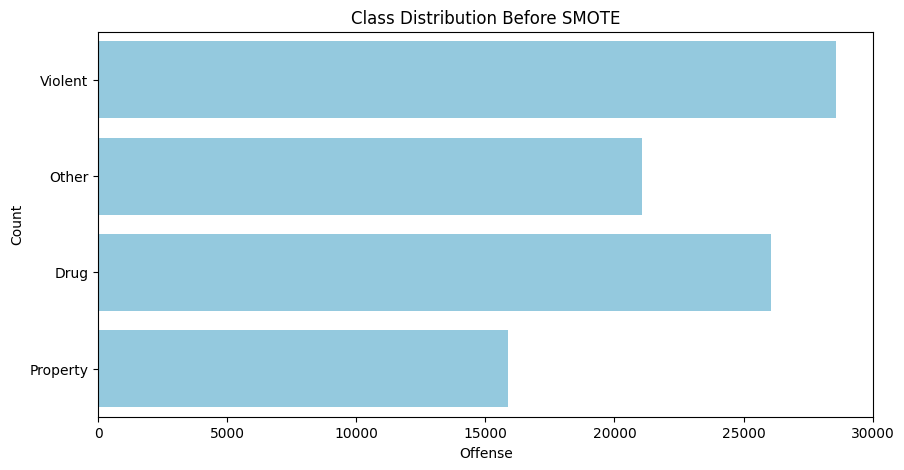

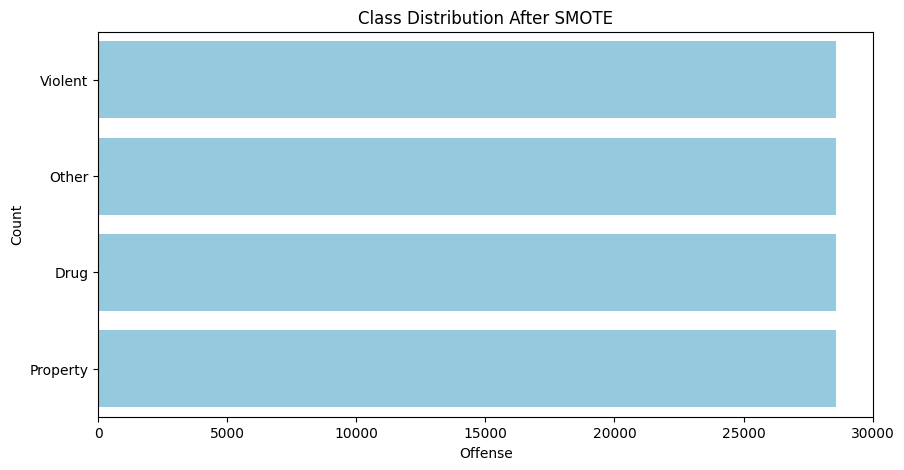

In [538]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution before SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(y, color='skyblue')
plt.title('Class Distribution Before SMOTE')
plt.xlabel('Offense')
plt.ylabel('Count')
plt.show()

# Plot class distribution after SMOTE
plt.figure(figsize=(10, 5))
sns.countplot(y_resampled, color='skyblue')
plt.title('Class Distribution After SMOTE')
plt.xlabel('Offense')
plt.ylabel('Count')
plt.show()
